# Исследование зависимости стоимости жилья в Тегеране (Иран) от различных факторов

In [83]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import scipy.stats as sts
import statsmodels.api as sm
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import seaborn as sns

In [84]:
#импортируем датасет
df = pd.read_excel('housePrice.xlsx')

#установим формат отображения данных
pd.set_option('display.float_format', '{:.2f}'.format)

df

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD)
0,63.00,1.00,True,True,True,Shahran,1850000000.00,61666.67
1,60.00,1.00,True,True,True,Shahran,1850000000.00,61666.67
2,79.00,2.00,True,True,True,Pardis,550000000.00,18333.33
3,95.00,2.00,True,True,True,Shahrake Qods,902500000.00,30083.33
4,123.00,2.00,True,True,True,Shahrake Gharb,7000000000.00,233333.33
...,...,...,...,...,...,...,...,...
3469,86.00,2.00,True,True,True,Southern Janatabad,3500000000.00,116666.67
3470,83.00,2.00,True,True,True,Niavaran,6800000000.00,226666.67
3471,75.00,2.00,False,False,False,Parand,365000000.00,12166.67
3472,105.00,2.00,True,True,True,Dorous,5600000000.00,186666.67


# Корректировка данных

Посмотрим на пропуски в данных, при их наличии - удалим их

In [85]:
df.isnull().sum()

,0
Area,1
Room,1
Parking,1
Warehouse,1
Elevator,1
Address,24
Price,1
Price(USD),1


Пропуски найдены во всех переменных

In [86]:
df.dropna(inplace = True)

#повторная проверка
df.isnull().sum()

,0
Area,0
Room,0
Parking,0
Warehouse,0
Elevator,0
Address,0
Price,0
Price(USD),0


In [87]:
#смотрим информацию о переменных
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3450 entries, 0 to 3473
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Area        3450 non-null   float64
 1   Room        3450 non-null   float64
 2   Parking     3450 non-null   object 
 3   Warehouse   3450 non-null   object 
 4   Elevator    3450 non-null   object 
 5   Address     3450 non-null   object 
 6   Price       3450 non-null   float64
 7   Price(USD)  3450 non-null   float64
dtypes: float64(4), object(4)
memory usage: 242.6+ KB


In [88]:
#вводим необходимые корректировки

#изменили тип данных для дамми-переменных
df['Parking'] = df['Parking'].astype(bool)
df['Warehouse'] = df['Warehouse'].astype(bool)
df['Elevator'] = df['Elevator'].astype(bool)

#удалили переменную, которую мы не будем использовать
df.drop(columns=['Price'], inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3450 entries, 0 to 3473
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Area        3450 non-null   float64
 1   Room        3450 non-null   float64
 2   Parking     3450 non-null   bool   
 3   Warehouse   3450 non-null   bool   
 4   Elevator    3450 non-null   bool   
 5   Address     3450 non-null   object 
 6   Price(USD)  3450 non-null   float64
dtypes: bool(3), float64(3), object(1)
memory usage: 144.9+ KB


# Предварительный анализ данных: (1) Анализ выбросов

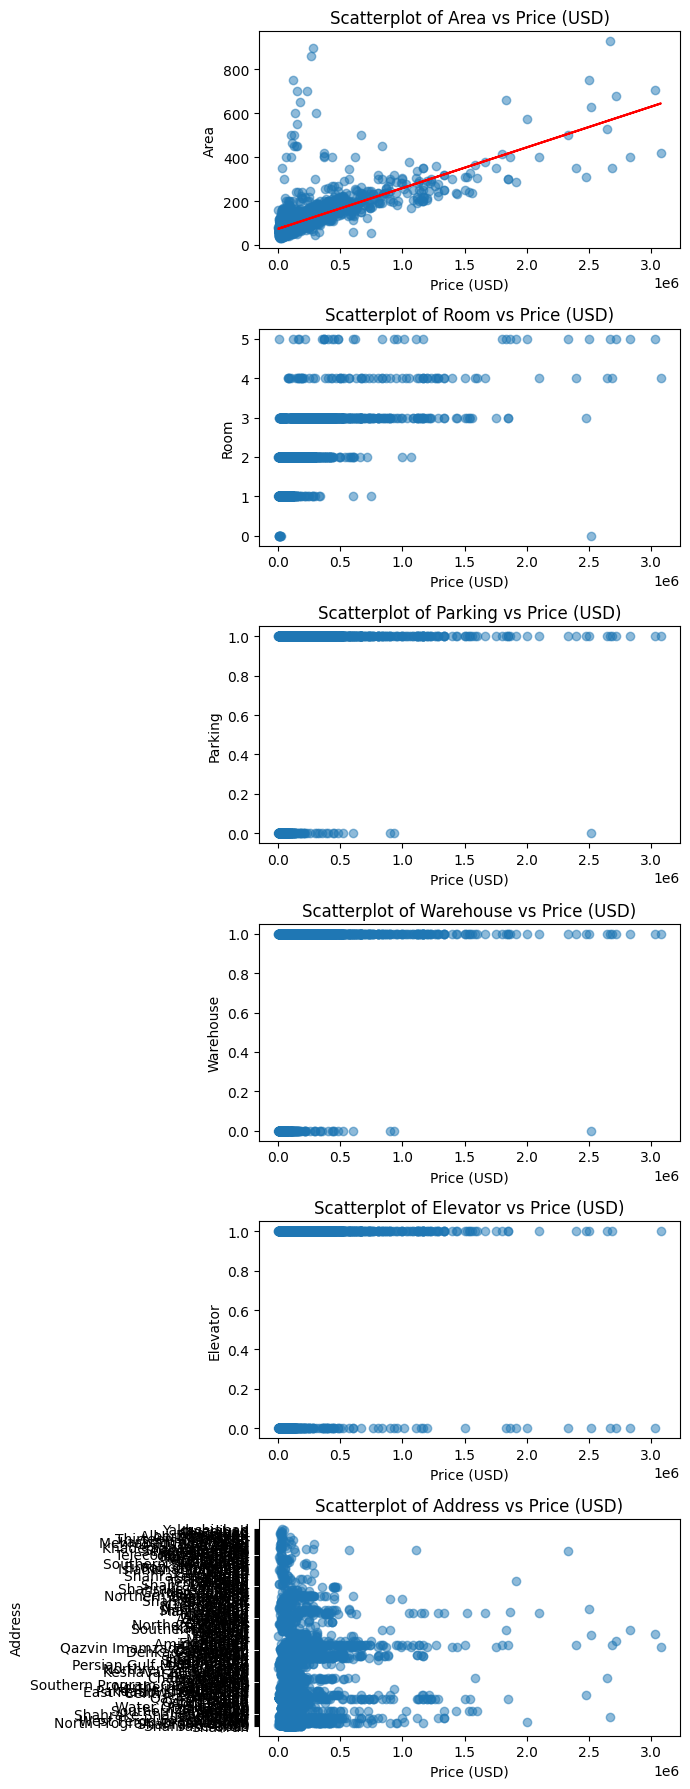

In [89]:
variables = ['Area', 'Room', 'Parking', 'Warehouse', 'Elevator', 'Address']

# Количество графиков
num_vars = len(variables)

# Настройка размеров графика
plt.figure(figsize=(7, 3 * num_vars))

# Цикл по переменным
for i, var in enumerate(variables):
    plt.subplot(num_vars, 1, i + 1)  # Создаем подграфик
    plt.scatter(df['Price(USD)'], df[var], alpha=0.5)  # Строим scatter plot

    # Для переменной Area добавляем линию тренда
    if var == 'Area':
        # Линия тренда
        z = np.polyfit(df['Price(USD)'], df['Area'], 1)
        p = np.poly1d(z)
        plt.plot(df['Price(USD)'], p(df['Price(USD)']), color='red')

    # Подписываем оси и заголовок
    plt.xlabel('Price (USD)')
    plt.ylabel(var)
    plt.title(f'Scatterplot of {var} vs Price (USD)')

# Отображаем графики
plt.tight_layout()
plt.show()

Для переменной *Address* попробуем создать более понятную self-explanatory визуализацию, путем разбивки адресов по группам

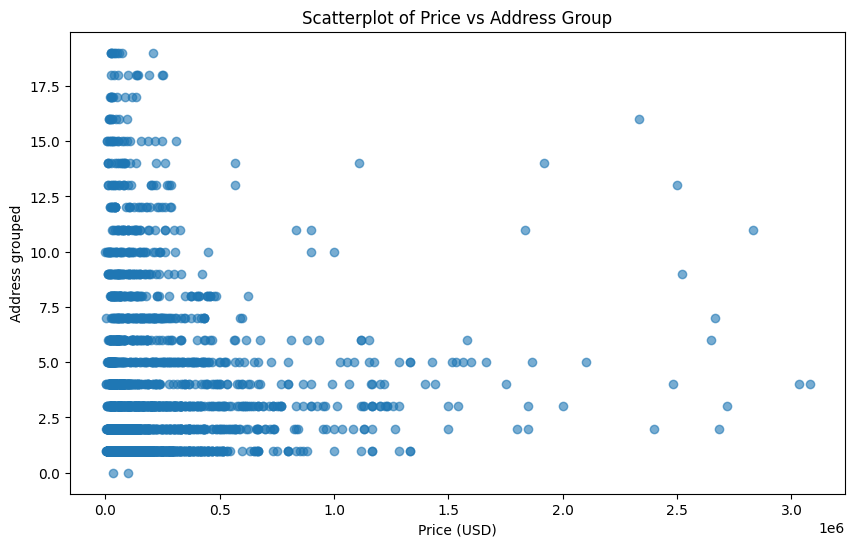

In [90]:
# Получаем частоты встречаемости адресов
address_counts = df['Address'].value_counts()

# Разбиваем адреса на группы
grouped_addresses = {i + 1: address_counts.iloc[i*10:(i+1)*10].index.tolist() for i in range(19)}  # 20 групп по 10 адресов

# Создаем список для хранения средней цены по группам
group_avg_prices = []

# Для каждой группы подсчитываем среднюю цену
for group_num, addresses in grouped_addresses.items():
    group_data = df[df['Address'].isin(addresses)]
    avg_price = group_data['Price(USD)'].mean()
    group_avg_prices.append({'Group': group_num, 'Average_Price': avg_price})

# Преобразуем список в DataFrame
grouped_df = pd.DataFrame(group_avg_prices)

# Добавляем информацию о группе в основной DataFrame для визуализации
df['Group'] = 0  # Инициализируем столбец групп
for group_num, addresses in grouped_addresses.items():
    df.loc[df['Address'].isin(addresses), 'Group'] = group_num

# Построение scatterplot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['Price(USD)'], df['Group'], cmap='viridis', alpha=0.6)
#plt.colorbar(scatter, label='Group')
plt.xlabel('Price (USD)')
plt.ylabel('Address grouped')
plt.title('Scatterplot of Price vs Address Group')

# Отображаем графики
plt.show()

# Предварительный анализ данных: (2) Описательные статистики переменных

In [91]:
metrics = {'Statistic': ['Minimum', 'Maximum', 'Median', 'Mode', 'Mean', 'Standard Deviation'],}

values = df[['Area', 'Room', 'Price(USD)']]

for i in values:
    metrics[i] = [
        df[i].min(),
        df[i].max(),
        df[i].median(),
        df[i].mode()[0],  # берем первую моду
        df[i].mean(),
        df[i].std(),
    ]

#создали соответствующую таблицу
df_metrics = pd.DataFrame(metrics)

df_metrics

,Statistic,Area,Room,Price(USD)
0,Minimum,30.00,0.00,120.00
1,Maximum,929.00,5.00,3080000.00
2,Median,90.00,2.00,96666.67
3,Mode,75.00,2.00,66666.67
4,Mean,106.92,2.08,179185.42
5,Standard Deviation,69.55,0.76,270863.93


# Предварительный анализ данных: (3) Корреляционнная матрица

In [92]:
corr_matrix = df.corr(numeric_only = True)

corr_matrix

,Area,Room,Parking,Warehouse,Elevator,Price(USD),Group
Area,1.00,0.67,0.20,0.08,0.05,0.72,0.11
Room,0.67,1.00,0.27,0.13,0.18,0.57,0.04
Parking,0.20,0.27,1.00,0.43,0.43,0.19,-0.11
Warehouse,0.08,0.13,0.43,1.00,0.20,0.11,-0.08
Elevator,0.05,0.18,0.43,0.20,1.00,0.11,-0.09
Price(USD),0.72,0.57,0.19,0.11,0.11,1.00,0.05
Group,0.11,0.04,-0.11,-0.08,-0.09,0.05,1.00


**Интерпретация**: наша целевая переменная наиболее коррелируема с *площадью жилья и количеством комнат в нем*, что вполне очевидно.

# Предварительный анализ данных: (4) Визуализация

**Numeric variables visualization**

In [93]:
#напишем функцию, которая накладываает на график кривую нормального распределения. Она нам понадобится в будущем для более точных и надежных выводов

#будем использовать это для референса

def norm(data):
    mu = np.mean(data.astype(float))  # Среднее значение
    sigma = np.std(data.astype(float))  # Стандартное отклонение

    x = np.linspace(0, data.astype(float).max(), 1000)
    y = (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp((-1/2) * ((x - mu) / sigma)**2) #функция плотности нормального распределения

    return plt.plot(x, y, color = 'r')

Распределение переменной *Area*

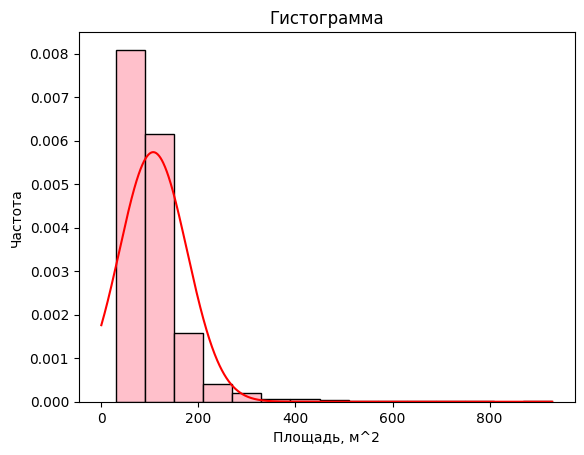

In [94]:
plt.hist(df['Area'], bins = 15, color = 'pink', edgecolor = 'black', density = True)
plt.xlabel('Площадь, м^2')
plt.ylabel('Частота')
plt.title('Гистограмма')
norm(df['Area'])

Как мы видим, переменная *Area* не имеет нормального распределения, при построении модели мы будем это учитывать

Распределение переменной *Room*

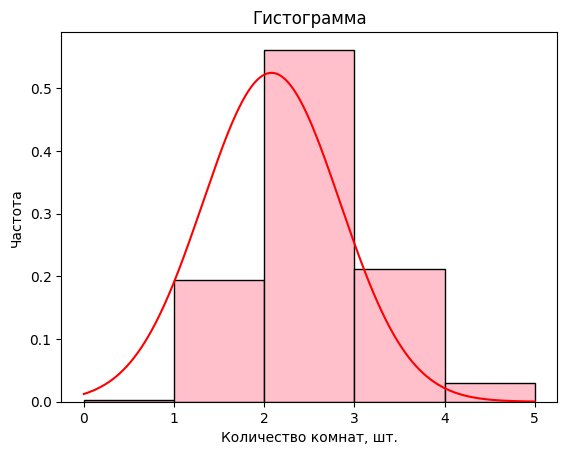

In [95]:
plt.hist(df['Room'], bins = 5, color = 'pink', edgecolor = 'black', density = True)
plt.xlabel('Количество комнат, шт.')
plt.ylabel('Частота')
plt.title('Гистограмма')
norm(df['Room'])

Как мы видим, переменная *Room* имеет близкое к нормальному распределение, при построении модели мы будем это учитывать

Распределение переменной *Price*

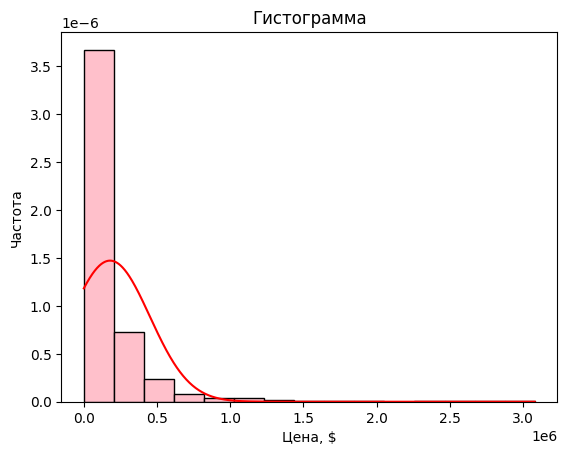

In [96]:
plt.hist(df['Price(USD)'], bins = 15, color = 'pink', edgecolor = 'black', density = True)
plt.xlabel('Цена, $')
plt.ylabel('Частота')
plt.title('Гистограмма')
norm(df['Price(USD)'])

Как мы видим, переменная *Price* не имеет нормального распределения, при построении модели мы будем это учитывать

**bool variables visualization**

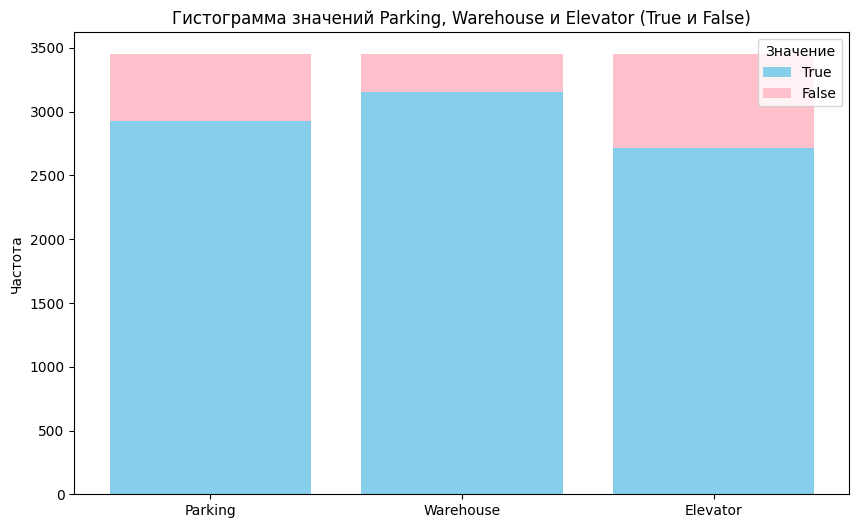

In [97]:
#пустая фигура для графиков
plt.figure(figsize=(10, 6))

#итерируемся по столбцам для построения гистограммы
for column in ['Parking', 'Warehouse', 'Elevator']:

    counts = df[column].value_counts()

    #строим гистограмму
    plt.bar(column, counts[True], color='skyblue', label='True' if column == 'Parking' else "")
    plt.bar(column, counts[False], bottom=counts[True], color='pink', label='False' if column == 'Parking' else "")

#подписываем графики

plt.ylabel('Частота')
plt.title('Гистограмма значений Parking, Warehouse и Elevator (True и False)')
plt.xticks(rotation=0)  #поворачиваем метки по оси X для удобства чтения
plt.legend(title='Значение')

plt.show()

**categorial variables visualization**

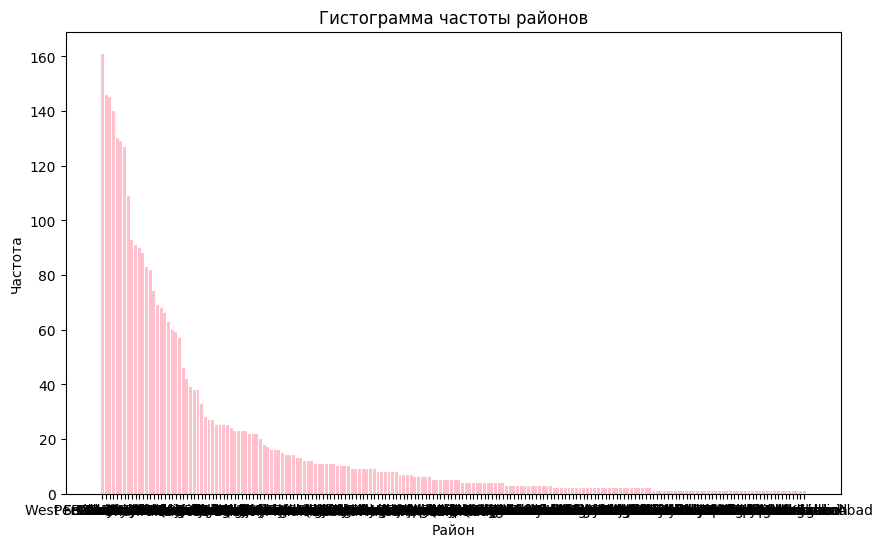

In [98]:
#частота каждого района
address_counts = df['Address'].value_counts()

#гистограмма
plt.figure(figsize=(10, 6))
plt.bar(address_counts.index, address_counts.values, color='pink')
plt.xlabel('Район')
plt.ylabel('Частота')
plt.title('Гистограмма частоты районов')
plt.show()

# OHE

In [99]:
def categorize_Address(Address):
    if Address == 'Punak':
        return 'Punak'
    elif Address == 'Pardis':
        return 'Pardis'
    else:
        return 'others'

# Применяем функцию к столбцу address
df['Address_category'] = df['Address'].apply(categorize_Address)

# Проводим one-hot encoding
one_hot_encoded = pd.get_dummies(df['Address_category'], prefix='Address' )

# Объединяем с оригинальным DataFrame
df_ohe = pd.concat([df, one_hot_encoded], axis=1)

df_ohe

,Area,Room,Parking,Warehouse,Elevator,Address,Price(USD),Group,Address_category,Address_Pardis,Address_Punak,Address_others
0,63.00,1.00,True,True,True,Shahran,61666.67,1,others,False,False,True
1,60.00,1.00,True,True,True,Shahran,61666.67,1,others,False,False,True
2,79.00,2.00,True,True,True,Pardis,18333.33,1,Pardis,True,False,False
3,95.00,2.00,True,True,True,Shahrake Qods,30083.33,2,others,False,False,True
4,123.00,2.00,True,True,True,Shahrake Gharb,233333.33,3,others,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...
3469,86.00,2.00,True,True,True,Southern Janatabad,116666.67,1,others,False,False,True
3470,83.00,2.00,True,True,True,Niavaran,226666.67,2,others,False,False,True
3471,75.00,2.00,False,False,False,Parand,12166.67,1,others,False,False,True
3472,105.00,2.00,True,True,True,Dorous,186666.67,6,others,False,False,True


Переменная *Address* была разбита на 3 категории: Punak, Pardis и others. Теперь изменим тип данных для дамми-переменных.

In [100]:
#выделяем базовую перменную - others, чтобы избежать ловушки дамми
df_ohe = df_ohe.drop(columns=['Address_others'])
#изменили тип данных для дамми-переменных
df_ohe['Address_Pardis'] = df_ohe['Address_Pardis'].astype(bool)
df_ohe['Address_Punak'] = df_ohe['Address_Punak'].astype(bool)

df_ohe = df_ohe.drop(columns=['Address_category'])
df_ohe = df_ohe.drop(columns=['Group'])
#df_ohe = df_ohe.drop(columns=['Area_sq'])
df_ohe = df_ohe.replace({True: 1, False: 0})
df_ohe

,Area,Room,Parking,Warehouse,Elevator,Address,Price(USD),Address_Pardis,Address_Punak
0,63.00,1.00,1,1,1,Shahran,61666.67,0,0
1,60.00,1.00,1,1,1,Shahran,61666.67,0,0
2,79.00,2.00,1,1,1,Pardis,18333.33,1,0
3,95.00,2.00,1,1,1,Shahrake Qods,30083.33,0,0
4,123.00,2.00,1,1,1,Shahrake Gharb,233333.33,0,0
...,...,...,...,...,...,...,...,...,...
3469,86.00,2.00,1,1,1,Southern Janatabad,116666.67,0,0
3470,83.00,2.00,1,1,1,Niavaran,226666.67,0,0
3471,75.00,2.00,0,0,0,Parand,12166.67,0,0
3472,105.00,2.00,1,1,1,Dorous,186666.67,0,0


# Оценка модели: (1) модель с нескорретированными данными

In [101]:
# Выделяем независимые и зависимую переменные
X = df_ohe[['Area', 'Room', 'Parking', 'Warehouse', 'Elevator', 'Address_Pardis', 'Address_Punak']]  # Независимые переменные
y = df_ohe['Price(USD)'] # Зависимая переменная

# Добавляем константу для свободного члена
X = sm.add_constant(X)

model_1 = sm.OLS(y, X).fit()
summary_df=model_1.summary()

summary_df

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Price(USD)   R-squared:                       0.549
Model:                            OLS   Adj. R-squared:                  0.548
Method:                 Least Squares   F-statistic:                     598.8
Date:                Fri, 13 Dec 2024   Prob (F-statistic):               0.00
Time:                        12:01:15   Log-Likelihood:                -46678.
No. Observations:                3450   AIC:                         9.337e+04
Df Residuals:                    3442   BIC:                         9.342e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -2.332e+05   1.32e+04    -17.622      0.000   -2.59e+05   -2.07e+05
Area            2442.6981     60.774     40.193      0.000    2323.542    2561.854
Room            4.623e+04   5671.303      8.152      0.000    3.51e+04    5.74e+04
Parking        -3437.3017   1.06e+04     -0.323      0.747   -2.43e+04    1.74e+04
Warehouse       3.573e+04   1.23e+04      2.895      0.004    1.15e+04    5.99e+04
Elevator        3.953e+04   8496.459      4.652      0.000    2.29e+04    5.62e+04
Address_Pardis -1.396e+05   1.55e+04     -9.006      0.000    -1.7e+05   -1.09e+05
Address_Punak    -77.1258   1.48e+04     -0.005      0.996   -2.91e+04     2.9e+04
==============================================================================
Omnibus:                     1561.698   Durbin-Watson:                   1.847
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           169063.024
Skew:                           1.178   Prob(JB):                         0.00
Kurtosis:                      37.213   Cond. No.                         676.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [102]:
html_summary = model_1.summary().as_html()

# Сохранение в файл
with open('summary1.html', 'w') as f:
    f.write(html_summary)

# Оценка модели: (1) модель с удалением выбросов

Теперь сделаем корректировку модели, удалив выбросы, связанные с предполагаемыми ошибками в данных и оценим линейную регрессию заново.

Для начала изучим выбросы в перменной *Room*. Удалим выброс, связанный с квартирой стоимость 2520000.00 (USD)

In [103]:
df_ohe[df_ohe['Room']==0.00]

,Area,Room,Parking,Warehouse,Elevator,Address,Price(USD),Address_Pardis,Address_Punak
103,40.00,0.00,0,0,0,Shahrake Qods,8266.67,0,0
137,40.00,0.00,0,0,0,Pakdasht,5500.00,0,0
1167,40.00,0.00,0,1,0,Ostad Moein,21666.67,0,0
2081,40.00,0.00,0,0,0,Pakdasht,5500.00,0,0
2100,43.00,0.00,0,1,0,Nasim Shahr,12000.00,0,0
2621,50.00,0.00,1,1,1,Northern Chitgar,11500.00,0,0
2717,110.00,0.00,1,1,1,Parand,3400.00,0,0
3102,630.00,0.00,0,0,0,Tajrish,2520000.00,0,0
3206,30.00,0.00,0,1,0,Ostad Moein,16666.67,0,0
3430,54.00,0.00,0,0,0,Shahrake Qods,15666.67,0,0


In [104]:
df_ohe.drop(index=3102, inplace = True)

Смотрим выбросы в переменной *Area* с площадью больше 800 кв. м. Исключим данные значения, так как это свящано с ошибками в данных (см. объяснение в текстовом файле)

In [105]:
df_ohe[df_ohe['Area'] > 800.00]

,Area,Room,Parking,Warehouse,Elevator,Address,Price(USD),Address_Pardis,Address_Punak
573,863.00,2.00,1,1,1,Gheitarieh,261000.00,0,0
1691,929.00,5.00,1,1,0,Zafar,2666666.67,0,0
1971,900.00,3.00,1,1,0,Damavand,283333.33,0,0


In [106]:
df_ohe.drop(index=573, inplace=True)
df_ohe.drop(index=1691, inplace=True)
df_ohe.drop(index=1971, inplace=True)

In [107]:
# Выделяем независимые и зависимую переменные
X = df_ohe[['Area', 'Room', 'Parking', 'Warehouse', 'Elevator', 'Address_Pardis', 'Address_Punak']]  # Независимые переменные
y = df_ohe['Price(USD)'] # Зависимая переменная

# Добавляем константу для свободного члена
X = sm.add_constant(X)

model_2 = sm.OLS(y, X).fit()
summary_df_2=model_2.summary()
summary_df_2

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Price(USD)   R-squared:                       0.563
Model:                            OLS   Adj. R-squared:                  0.562
Method:                 Least Squares   F-statistic:                     632.7
Date:                Fri, 13 Dec 2024   Prob (F-statistic):               0.00
Time:                        12:01:16   Log-Likelihood:                -46491.
No. Observations:                3446   AIC:                         9.300e+04
Df Residuals:                    3438   BIC:                         9.305e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -2.355e+05   1.28e+04    -18.416      0.000   -2.61e+05    -2.1e+05
Area            2681.1743     65.940     40.661      0.000    2551.889    2810.460
Room            3.293e+04   5743.377      5.734      0.000    2.17e+04    4.42e+04
Parking        -3992.1508   1.02e+04     -0.390      0.697   -2.41e+04    1.61e+04
Warehouse       4.049e+04   1.19e+04      3.407      0.001    1.72e+04    6.38e+04
Elevator        4.111e+04   8182.215      5.025      0.000    2.51e+04    5.72e+04
Address_Pardis  -1.39e+05   1.49e+04     -9.325      0.000   -1.68e+05    -1.1e+05
Address_Punak   1922.4052   1.43e+04      0.135      0.893    -2.6e+04    2.99e+04
==============================================================================
Omnibus:                     1569.461   Durbin-Watson:                   1.856
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           168386.542
Skew:                           1.194   Prob(JB):                         0.00
Kurtosis:                      37.162   Cond. No.                         661.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [108]:
html_summary_1 = model_2.summary().as_html()

# Сохранение в файл
with open('summary2.html', 'w') as f:
    f.write(html_summary_1)

# Оценка модели: (3) модель с логарифмированием переменных

In [109]:
#создадим датафрейм для логарифмов
df_log = df_ohe.copy()

#логарифмируем переменные
df_log[["Area", "Price(USD)"]] = np.log1p(df_log[["Area", "Price(USD)"]])

#смотрим на результат
df_log

,Area,Room,Parking,Warehouse,Elevator,Address,Price(USD),Address_Pardis,Address_Punak
0,4.16,1.00,1,1,1,Shahran,11.03,0,0
1,4.11,1.00,1,1,1,Shahran,11.03,0,0
2,4.38,2.00,1,1,1,Pardis,9.82,1,0
3,4.56,2.00,1,1,1,Shahrake Qods,10.31,0,0
4,4.82,2.00,1,1,1,Shahrake Gharb,12.36,0,0
...,...,...,...,...,...,...,...,...,...
3469,4.47,2.00,1,1,1,Southern Janatabad,11.67,0,0
3470,4.43,2.00,1,1,1,Niavaran,12.33,0,0
3471,4.33,2.00,0,0,0,Parand,9.41,0,0
3472,4.66,2.00,1,1,1,Dorous,12.14,0,0


In [110]:
#выделяем независимые и зависимую переменные
X = df_log[['Area', 'Room', 'Parking', 'Warehouse', 'Elevator', 'Address_Pardis', 'Address_Punak']]  # Независимые переменные
y = df_log['Price(USD)'] # Зависимая переменная

#константа для свободного члена
X = sm.add_constant(X)

model_3 = sm.OLS(y, X).fit()
#summary_df = model_3.summary()

pd.set_option('display.float_format', '{:.2f}'.format)

model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Price(USD)   R-squared:                       0.638
Model:                            OLS   Adj. R-squared:                  0.638
Method:                 Least Squares   F-statistic:                     866.7
Date:                Fri, 13 Dec 2024   Prob (F-statistic):               0.00
Time:                        12:01:16   Log-Likelihood:                -3447.6
No. Observations:                3446   AIC:                             6911.
Df Residuals:                    3438   BIC:                             6960.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              3.9803      0.163     24.419      0.000       3.661       4.300
Area               1.4278      0.045     31.770      0.000       1.340       1.516
Room               0.0817      0.026      3.122      0.002       0.030       0.133
Parking            0.4674      0.039     12.072      0.000       0.391       0.543
Warehouse          0.3079      0.045      6.890      0.000       0.220       0.395
Elevator           0.2480      0.031      8.088      0.000       0.188       0.308
Address_Pardis    -1.5758      0.056    -28.107      0.000      -1.686      -1.466
Address_Punak      0.2614      0.054      4.869      0.000       0.156       0.367
==============================================================================
Omnibus:                      918.359   Durbin-Watson:                   1.766
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4226.982
Skew:                          -1.212   Prob(JB):                         0.00
Kurtosis:                       7.854   Cond. No.                         81.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [111]:
html_summary_3 = model_3.summary().as_html()

# Сохранение в файл
with open('summary.html', 'w') as f:
    f.write(html_summary_3)

# Оценка модели: (3) модель с отбором наиболее информативных переменных

In [112]:
#шаг 1

df_ohe.corr(numeric_only = True)

,Area,Room,Parking,Warehouse,Elevator,Price(USD),Address_Pardis,Address_Punak
Area,1.00,0.71,0.21,0.09,0.07,0.74,-0.03,-0.07
Room,0.71,1.00,0.27,0.13,0.18,0.58,-0.02,-0.05
Parking,0.21,0.27,1.00,0.43,0.43,0.20,0.05,0.06
Warehouse,0.09,0.13,0.43,1.00,0.20,0.12,0.02,0.05
Elevator,0.07,0.18,0.43,0.20,1.00,0.12,0.09,0.00
Price(USD),0.74,0.58,0.20,0.12,0.12,1.00,-0.12,-0.04
Address_Pardis,-0.03,-0.02,0.05,0.02,0.09,-0.12,1.00,-0.05
Address_Punak,-0.07,-0.05,0.06,0.05,0.00,-0.04,-0.05,1.00


In [113]:
#выделяем независимые и зависимую переменные
X = df_ohe['Area']
y = df_ohe['Price(USD)']

    #константа для свободного члена
X = sm.add_constant(X)

    #обучаем модель
model = sm.OLS(y, X).fit()
results = model
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Price(USD)   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                     4049.
Date:                Fri, 13 Dec 2024   Prob (F-statistic):               0.00
Time:                        12:01:16   Log-Likelihood:                -46578.
No. Observations:                3446   AIC:                         9.316e+04
Df Residuals:                    3444   BIC:                         9.317e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.401e+05   5855.699    -23.918      0.000   -1.52e+05   -1.29e+05
Area        2995.8252     47.081     63.632      0.000    2903.516    3088.134
==============================================================================
Omnibus:                     1154.256   Durbin-Watson:                   1.844
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           192367.597
Skew:                           0.417   Prob(JB):                         0.00
Kurtosis:                      39.593   Cond. No.                         238.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [114]:
#шаг 2

features = ['Room', 'Warehouse', 'Parking', 'Elevator', 'Address_Punak', 'Address_Pardis']
r2_scores = []

for feature in features:
    #выделяем независимые и зависимую переменные
    X = df_ohe[[feature, 'Area']]
    y = df_ohe['Price(USD)']

    #константа для свободного члена
    X = sm.add_constant(X)

    #обучаем модель
    model = sm.OLS(y, X).fit()
    results = model

    #достаем R^2
    r2 = results.rsquared
    r2_scores.append(r2)

    print(f'R^2 для {feature}: {r2}')

max_r2 = max(r2_scores)
max_r2_var = features[r2_scores.index(max_r2)]

# Вывод максимального R^2 и соответствующей переменной
print(f'Максимальное R^2: {max_r2}, соответствующая переменная: {max_r2_var}')

R^2 для Room: 0.5468595460611629
R^2 для Warehouse: 0.54360544618195
R^2 для Parking: 0.5424011722493975
R^2 для Elevator: 0.5455996102436007
R^2 для Address_Punak: 0.540457827597316
R^2 для Address_Pardis: 0.5502102073984576
Максимальное R^2: 0.5502102073984576, соответствующая переменная: Address_Pardis


In [115]:
#шаг 3
features = ['Room', 'Warehouse', 'Parking', 'Elevator', 'Address_Punak']
r2_scores = []

for feature in features:
    #выделяем независимые и зависимую переменные
    X = df_ohe[[feature, 'Area', 'Address_Pardis']]
    y = df_ohe['Price(USD)']

    #константа для свободного члена
    X = sm.add_constant(X)

    #обучаем модель
    model = sm.OLS(y, X).fit()
    results = model

    #достаем R^2
    r2 = results.rsquared
    r2_scores.append(r2)

    print(f'R^2 для {feature}: {r2}')

max_r2 = max(r2_scores)
max_r2_var = features[r2_scores.index(max_r2)]

# Вывод максимального R^2 и соответствующей переменной
print(f'Максимальное R^2: {max_r2}, соответствующая переменная: {max_r2_var}')

R^2 для Room: 0.5567936922190639
R^2 для Warehouse: 0.5536764045950839
R^2 для Parking: 0.5528296744688985
R^2 для Elevator: 0.5568684352995142
R^2 для Address_Punak: 0.5502303534896196
Максимальное R^2: 0.5568684352995142, соответствующая переменная: Elevator


In [116]:
#шаг 4
features = ['Room', 'Warehouse', 'Parking', 'Address_Punak']
r2_scores = []

for feature in features:
    #выделяем независимые и зависимую переменные
    X = df_ohe[[feature, 'Area', 'Address_Pardis', 'Elevator']]
    y = df_ohe['Price(USD)']

    #константа для свободного члена
    X = sm.add_constant(X)

    #обучаем модель
    model = sm.OLS(y, X).fit()
    results = model

    #достаем R^2
    r2 = results.rsquared
    r2_scores.append(r2)

    print(f'R^2 для {feature}: {r2}')

max_r2 = max(r2_scores)
max_r2_var = features[r2_scores.index(max_r2)]

# Вывод максимального R^2 и соответствующей переменной
print(f'Максимальное R^2: {max_r2}, соответствующая переменная: {max_r2_var}')

R^2 для Room: 0.5613579118335008
R^2 для Warehouse: 0.5587813649765565
R^2 для Parking: 0.5572068020969327
R^2 для Address_Punak: 0.5568798869436
Максимальное R^2: 0.5613579118335008, соответствующая переменная: Room


In [117]:
#шаг 5
features = ['Warehouse', 'Parking', 'Address_Punak']
r2_scores = []

for feature in features:
    #выделяем независимые и зависимую переменные
    X = df_ohe[[feature, 'Area', 'Address_Pardis', 'Elevator', 'Room']]
    y = df_ohe['Price(USD)']

    #константа для свободного члена
    X = sm.add_constant(X)

    #обучаем модель
    model = sm.OLS(y, X).fit()
    results = model

    #достаем R^2
    r2 = results.rsquared
    r2_scores.append(r2)

    print(f'R^2 для {feature}: {r2}')

max_r2 = max(r2_scores)
max_r2_var = features[r2_scores.index(max_r2)]

# Вывод максимального R^2 и соответствующей переменной
print(f'Максимальное R^2: {max_r2}, соответствующая переменная: {max_r2_var}')

R^2 для Warehouse: 0.5629438060530734
R^2 для Parking: 0.561481877352906
R^2 для Address_Punak: 0.5613706199167199
Максимальное R^2: 0.5629438060530734, соответствующая переменная: Warehouse


In [118]:
#шаг 6
features = ['Parking', 'Address_Punak']
r2_scores = []

for feature in features:
    #выделяем независимые и зависимую переменные
    X = df_ohe[[feature, 'Area', 'Address_Pardis', 'Elevator', 'Room', 'Warehouse']]
    y = df_ohe['Price(USD)']

    #константа для свободного члена
    X = sm.add_constant(X)

    #обучаем модель
    model = sm.OLS(y, X).fit()
    results = model

    #достаем R^2
    r2 = results.rsquared
    r2_scores.append(r2)

    print(f'R^2 для {feature}: {r2}')

max_r2 = max(r2_scores)
max_r2_var = features[r2_scores.index(max_r2)]

# Вывод максимального R^2 и соответствующей переменной
print(f'Максимальное R^2: {max_r2}, соответствующая переменная: {max_r2_var}')

R^2 для Parking: 0.5629622799986771
R^2 для Address_Punak: 0.5629452799391754
Максимальное R^2: 0.5629622799986771, соответствующая переменная: Parking


In [119]:
#шаг 7
features = ['Address_Punak']
r2_scores = []

for feature in features:
    #выделяем независимые и зависимую переменные
    X = df_ohe[[feature, 'Area', 'Address_Pardis', 'Elevator', 'Room', 'Warehouse', 'Parking']]
    y = df_ohe['Price(USD)']

    #константа для свободного члена
    X = sm.add_constant(X)

    #обучаем модель
    model = sm.OLS(y, X).fit()
    results = model

    #достаем R^2
    r2 = results.rsquared
    r2_scores.append(r2)

    print(f'R^2 для {feature}: {r2}')

max_r2 = max(r2_scores)
max_r2_var = features[r2_scores.index(max_r2)]

# Вывод максимального R^2 и соответствующей переменной
print(f'Максимальное R^2: {max_r2}, соответствующая переменная: {max_r2_var}')


R^2 для Address_Punak: 0.5629645917187437
Максимальное R^2: 0.5629645917187437, соответствующая переменная: Address_Punak


# Тестирование гипотез: гипотеза (1)

                            OLS Regression Results                            
Dep. Variable:        Q("Price(USD)")   R-squared:                       0.499
Model:                            OLS   Adj. R-squared:                  0.498
Method:                 Least Squares   F-statistic:                     1712.
Date:                Fri, 13 Dec 2024   Prob (F-statistic):               0.00
Time:                        12:01:16   Log-Likelihood:                -4010.2
No. Observations:                3446   AIC:                             8026.
Df Residuals:                    3443   BIC:                             8045.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.6812      0.890      3.014      0.0

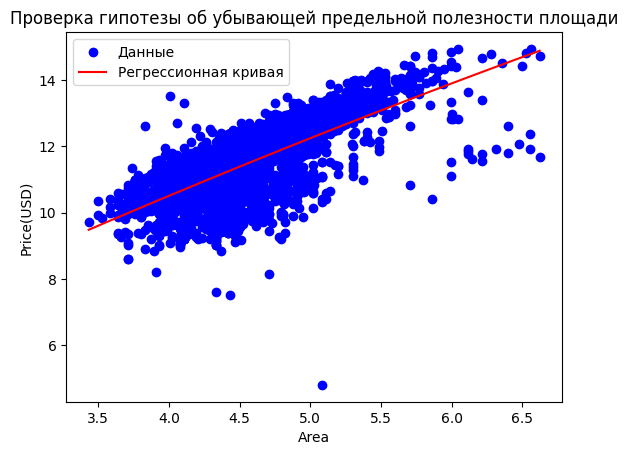

In [120]:
import statsmodels.formula.api as smf

# Проверка гипотезы об убывающей предельной полезности площади
# Идея: при увеличении площади дополнительный прирост цены должен уменьшаться.
# Это можно проверить, например, с помощью квадратичной регрессии:
# Если коэффициент при квадрате площади отрицательный,
# это будет означать, что при увеличении площади предельная полезность (наценка за дополнительные метры) снижается.

# Строим модель: Price(USD) ~ Area + Area^2
df_log['Area_sq'] = df_log['Area']**2
model = smf.ols('Q("Price(USD)") ~ Area + Area_sq', data=df_log).fit()

print(model.summary())

# Интерпретация:
# В модели вида Price = a + b*Area + c*(Area^2)
# если коэффициент c < 0 статистически значимо, это указывает на убывающий предел полезности.
coef = model.params['Area_sq']
p_value = model.pvalues['Area_sq']

print("\nКоэффициент при Area^2:", coef)
print("p-value для коэффициента при Area^2:", p_value)

if coef < 0 and p_value < 0.05:
    print("Результаты регрессии свидетельствуют о статистически значимом отрицательном квадратичном термине.")
    print("Это согласуется с гипотезой об убывающей предельной полезности площади.")
else:
    print("Нет статистически значимого отрицательного квадратичного термина.")
    print("Данный результат не подтверждает гипотезу об убывающей предельной полезности площади на этом уровне значимости.")

# Дополнительно визуализируем данные и подгонку
x_range = np.linspace(df_log['Area'].min(), df_log['Area'].max(), 100)
y_pred = model.predict(pd.DataFrame({'Area': x_range, 'Area_sq': x_range**2}))

plt.scatter(df_log['Area'], df_log['Price(USD)'], label='Данные', color='blue')
plt.plot(x_range, y_pred, label='Регрессионная кривая', color='red')
plt.xlabel('Area')
plt.ylabel('Price(USD)')
plt.title('Проверка гипотезы об убывающей предельной полезности площади')
plt.legend()
plt.show()

**Интерпретация**: Коэффициент при квадрате площади оказался отрицательным, но статистически незначимым (p-value был гораздо выше 0.05). Это означает, что на основании данных нельзя с уверенностью утверждать, что с увеличением площади прирост цены за дополнительный квадратный метр снижается. Другими словами, гипотеза об убывающей предельной полезности площади не получила статистически значимого подтверждения.

Нет достаточных оснований утверждать, что дополнительная площадь даёт всё меньший прирост в цене. Возможно, данные недостаточны или модель должна быть улучшена, но при текущем анализе гипотеза не подтвердилась.


# Тестирование гипотез: гипотеза (2)

In [121]:
# Цель: проверить гипотезу о том, что существуют устойчивые различия в цене жилья между районами, не объяснимые только характеристиками квартиры.
# Для этого можно использовать регрессионную модель с фиктивными переменными для района (Address), контролируя за такие факторы, как Area, Room, Parking, Warehouse, Elevator.

# Создаём модель: Price ~ C(Address) + Area + Room + Parking + Warehouse + Elevator
# C(Address) - указывает на то, что Address является категориальной переменной.
model = smf.ols('Q("Price(USD)") ~ C(Address) + Area + Room + Parking + Warehouse + Elevator', data=df_log).fit()

print(model.summary())

# Интерпретация:
# Если хотя бы один из коэффициентов, соответствующих фиктивным переменным районов (кроме базового),
# статистически значим, это свидетельствует о наличии устойчивых ценовых различий,
# которые не могут быть объяснены только характеристиками квартир.

# Проверим значимость групповых различий через F-тест.
# Это можно сделать, например, сравнив модель без района и с районом или
# проверив гипотезу о равенстве коэффициентов районов друг другу.

# Модель без районов:
model_no_address = smf.ols('Q("Price(USD)") ~ Area + Room + Parking + Warehouse + Elevator', data=df_log).fit()

# Проведем F-тест для проверки, что все коэфициенты Address равны 0
f_test_result = model.compare_f_test(model_no_address)
print("\nРезультаты F-теста между моделями с районами и без:")
print("F-статистика:", f_test_result[0])
print("p-value:", f_test_result[1])
print("df_diff:", f_test_result[2])

# Если p-value мало (например, меньше 0.05), то модель с районами статистически значимо лучше,
# чем модель без, что подтверждает гипотезу о существовании устойчивых различий в цене по районам.

                            OLS Regression Results                            
Dep. Variable:        Q("Price(USD)")   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     168.0
Date:                Fri, 13 Dec 2024   Prob (F-statistic):               0.00
Time:                        12:01:17   Log-Likelihood:                -1047.2
No. Observations:                3446   AIC:                             2488.
Df Residuals:                    3249   BIC:                             3699.
Df Model:                         196                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

**Из предоставленных результатов видно следующее:**

Многие коэффициенты для районов статистически значимы. Некоторые районы имеют более высокие цены, другие — более низкие, даже после учёта всех контролируемых характеристик квартиры.
F-тест сравнения модели с районами и без районов показал очень низкое p-value (близкое к нулю), что указывает на статистически значимое улучшение модели при учёте районов.

Данные подтверждают, что в исследуемых данных существуют устойчивые различия в ценах между районами, которые не объясняются только характеристиками самих квартир. Таким образом, гипотеза о наличии таких отличий подтверждается.

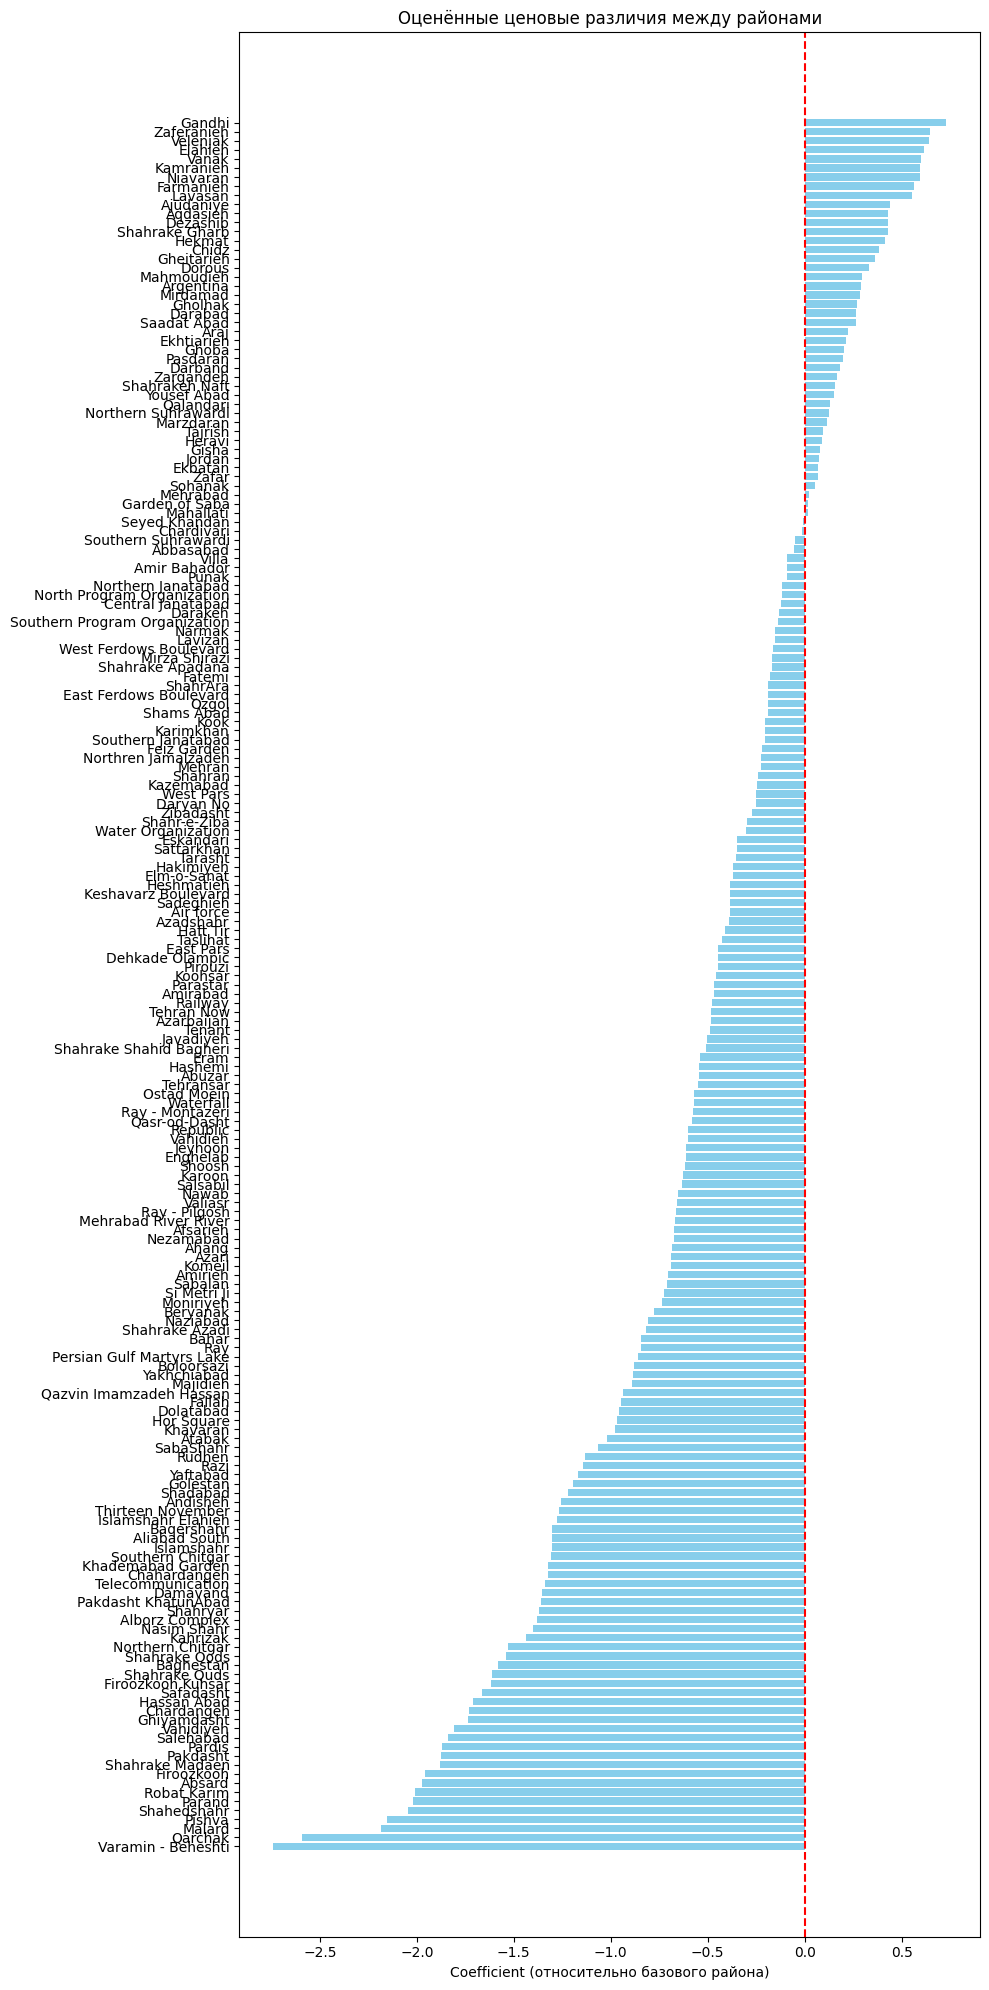

In [122]:
# Получим коэффициенты, относящиеся к фиктивным переменным районов
# Коэффициенты районов начинаются с 'C(Address)[T.xxxx]'
address_coefs = model.params.filter(like='C(Address)')

# Извлечём названия районов и соответствующие коэффициенты
addresses = [coef.split(']')[0].split('[T.')[1] for coef in address_coefs.index]
coef_values = address_coefs.values

# Создадим датафрейм для удобства
coef_df = pd.DataFrame({'Address': addresses, 'Coefficient': coef_values})

# Отсортируем по значению коэффициента
coef_df = coef_df.sort_values(by='Coefficient')

# Построим столбчатую диаграмму
plt.figure(figsize=(10, 20))
plt.barh(coef_df['Address'], coef_df['Coefficient'], color='skyblue')
plt.xlabel('Coefficient (относительно базового района)')
plt.title('Оценённые ценовые различия между районами')
plt.axvline(x=0, color='red', linestyle='--')  # линия для лучшего восприятия нулевого эффекта
plt.tight_layout()
plt.show()

На графике каждая горизонтальная полоса будет соответствовать какому-то району, а длина полосы – его оценённый эффект на цену относительно базового (опущенного) района, при прочих равных условиях (одинаковых характеристиках квартиры). Если коэффициент положительный и велик, это указывает, что цены в данном районе выше ожиданий, основанных только на характеристиках квартиры. Отрицательные значения говорят об обратном.